<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220624_future-sales-predict-feature-engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 향후 판매량 예측
 - 과거 판매 데이터를 기반으로 향후 판매량 예측
 - 문제유형 : 회귀
 - 평가지표 : RMSE
 - 사용모델 : LightGBM
 - 훈련/테스트/샘플제출 데이터 이외 3가지 추가데이터

  > shops : 상점에 관한 추가 정보

  > items : 상품에 관한 추가 정보

  > items_categories : 상품분류에 관한 추가 정보

 - 주의 사항 : 각 상점의 상품별 월간 판매량(타깃값)은 0개에서 20개 사이여야 한다

## 베이스라인 모델
 - 베이스라인 모델 : LightGBM
 - 평가지표 계산 함수 : RMSE(사이킷런 제공)

In [3]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/predict_future_sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [4]:
# LightGBM으로 범주형 데이터 모델링하면 불필요한 경고문구가 뜸
import warnings
warnings.filterwarnings(action='ignore') # 경고 문구 생략

### 피처 엔지니어링 1 : 피처명 한글화


In [6]:
sales_train = sales_train.rename(columns={'date':'날짜',
                                          'date_block_num':'월ID',
                                          'shop_id':'상점ID',
                                          'item_id':'상품ID',
                                          'item_price':'판매가',
                                          'item_cnt_day':'판매량'}) # rename()함수는 원본데이터 변화X
sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
shops = shops.rename(columns={'shop_name':'상점명',
                              'shop_id':'상점ID'})
shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
items = items.rename(columns={'item_name':'상품명',
                              'item_id':'상품ID',
                              'item_category_id':'상품분류ID'})
items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
item_categories = item_categories.rename(columns={'item_category_name':'상품분류명',
                                                  'item_category_id':'상품분류ID'})
item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
test = test.rename(columns={'shop_id':'상점ID',
                            'item_id':'상품ID'})
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 피처 엔지니어링 2 : 데이터 다운캐스팅
 - 더 작은 데이터 타입으로 변환
 - 데이터가 작은데 큰데이터 타입 사용시 메모리 낭비
 - 주어진 데이터 크기에 딱 맞는 타입 사용 권장
 - 판다스로 데이터 불러오면(기본설정) : 정수형은 int64, 실수형은 float64
  
  > 각각 정수형, 실수형에서 가장 큰 타입

 - object 타입이면 그대로 둠
 - 불리언 타입이면 int8로 바꿈
 - 정수형 타입이거나 실수형 타입 중 1.0 10.0과 같은 경우 가장작은 정수형 타입으로 바꿈
 - 그외 실수형 타입은 가장작은 실수형 타입으로 바꿈

In [45]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2 # memory_usage() : 피처별 용량(바이트)
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8') # astype() : Series에 적용할 수 있음
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all(): # 피처가 .0으로 만 되어있다면
            df[col] = pd.to_numeric(df[col], downcast='integer') # to_numeric() : 숫자형으로 변환, downcast='integer': 가장작은 정수타입으로
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100*(start_mem-end_mem) / start_mem))
    
    return df


In [48]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)   # 실행되면서 같은 변수에 할당이 되어도 함수 내부의 코드가 유효함

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


### 피처 엔지니어링 3 : 데이터 조합 생성


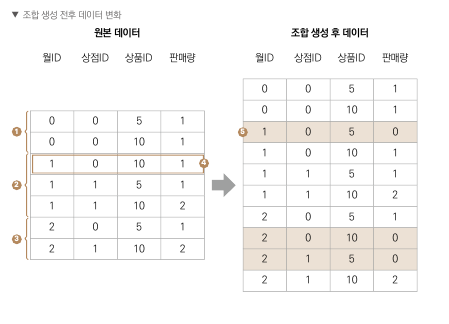

 - 한번이라도 등장한 상점ID, 상품ID가 있다면,
 - 다음 월ID에 판매량이 없더라도 0으로 표기하여 추가해 준다.

In [102]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 : 3가지 항목의 모든 조합을 만듦(사실은 월ID는 고정)
for i in sales_train['월ID'].unique(): # 0~33까지 순환
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique() # df.loc[조건, '피처명'] : 조건에 해당하는 피처를 시리즈로
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(list(product([i], all_shop, all_item))) # product() : iterable 객체를 파라미터로 받으므로 정수인 i를 → 리스트화 [i]
    # product(list1, list2, ...) : 각요소의 가능한 모든 조합을 만듦 → generator
    # list(product()) : list로 자료형 변환하면 출력결과 확인가능
    # [[(),(),... ]] : 리스트안에 하나의 요소(리스트)가 들어간 형태

idx_features = ['월ID','상점ID','상품ID'] # 기준 피처
# 리스트 타입인 train을 2차원 배열로 쌓고 데이터 프레임으로 변환
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


 - sales_train의 데이터 개수 : 2,935,849개
 - train의 데이터 개수 : 10,913,850개(3.7배 증가)
 - train을 앞으로 훈련 데이터로 사용

In [99]:
train.shape

(10913850, 3)

### 피처 엔지니어링 4 : 타깃값(월간 판매량) 추가
 - ['월ID', '상점ID', '상품ID']를 기준으로 groupby()

In [109]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기
group = sales_train.groupby(idx_features).agg({'판매량':sum})
# 인덱스 재설정
group = group.reset_index()
# 피처명을 '판매량'→'월간 판매량' 변경
group.rename(columns={'판매량':'월간 판매량'})

group

,월ID,상점ID,상품ID,판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


 - train과 group을 병합
 - 판매량이 없는 train의 데이터는 NaN 처리됨

In [104]:
# train과 group 병합하기
train = train.merge(group, on=idx_features, how='left')
# left(left join)를 꼭 붙혀야 하는 이유 : 오른쪽 데이터프레임에 없는 값은 NaN으로 나타난다.

train

,월ID,상점ID,상품ID,판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


---
**가비지 컬렉션**
group 데이터는 더이상 필요 없으니 할당된 메모리에서 해제


```
import gc # 가비지 컬렉터 불러오기

del group # 더는 사용하지 않는 변수 지정
gc.collect() # 가비지 컬렉션 수행
```
---




In [113]:
import gc
del group
gc.collect()

662

### 피처 엔지니어링 5 : 테스트 데이터 이어붙이기
 - 데이터 병합 전에 테스트 데이터를 이어붙여 한번에 병합되도록

In [114]:
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


 - test에 월ID 피처 추가
 - test데이터는 2015년 11월 판매기록, 따라서 월ID는 34로 설정

  > 2013년1월부터 2015년9월 : train 데이터세트

  > 2015년10월 : valid 데이터세트

  > 2015년11월 : test 데이터

In [115]:
test['월ID'] = 34
test.head()

,ID,상점ID,상품ID,월ID
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


 - ID는 식별자이고, 인덱스와 역할이 겹치므로 삭제
 - 이후 train 아래에 이어 붙임

In [116]:
# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, # 기존인덱스 무시
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

In [117]:
all_data

,월ID,상점ID,상품ID,판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
11128045,34,45,18454,NaN
11128046,34,45,16188,NaN
11128047,34,45,15757,NaN
11128048,34,45,19648,NaN


 - train과 group을 병합하면서 생긴 결측값

  > train에 추가한 데이터로 인해 생김

 - train과 test를 이어붙이면서 생긴 결측값  

  > test 데이터는 타깃값이 원래 없기때문


 - 모든 결측값 0으로 대체

In [118]:
all_data = all_data.fillna(0)
all_data

,월ID,상점ID,상품ID,판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0
